In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
#draw the sample distribution of each feature
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/property-sales/raw_sales.csv
/kaggle/input/property-sales/ma_lga_12345.csv


In [2]:
#load data
import pandas as pd

data = pd.read_csv('/kaggle/input/property-sales/raw_sales.csv')
data.head()
# Creating another dataset so we can re-use the original if we need it
df_grouped = data.copy()

# 1 Data preparation and general EDA

## 1-1 Data preparation

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


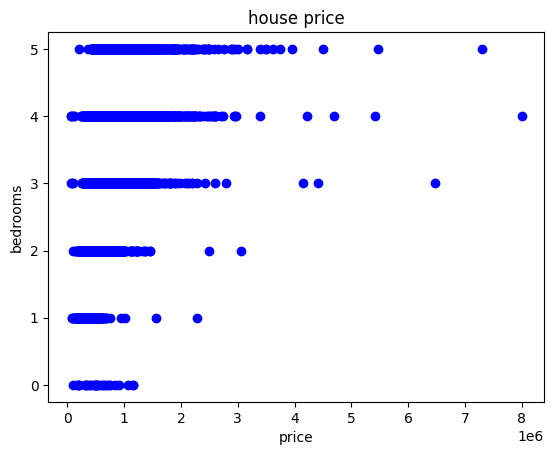

In [4]:
plt.scatter(x = data['price'],y = data['bedrooms'] ,color = 'blue',marker = "o")
plt.ylabel('bedrooms')
plt.xlabel('price')
plt.title('house price')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


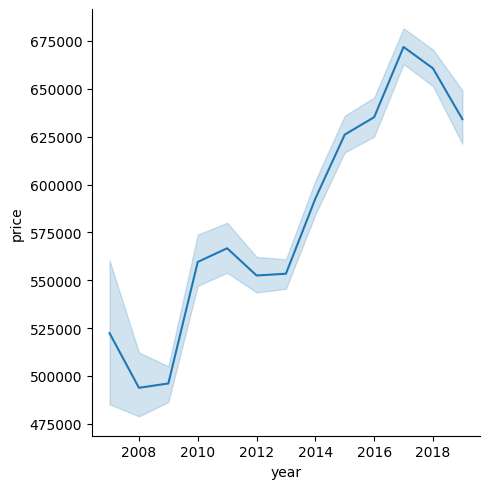

In [5]:
#time serie of price
import seaborn as sns

data["datesold"]=pd.to_datetime(data["datesold"])
data['year'] = data['datesold'].dt.year
data['month'] = data['datesold'].dt.month
sns.relplot(data=data[["price","year"]], x = "year",y = "price",kind = "line")
plt.show()

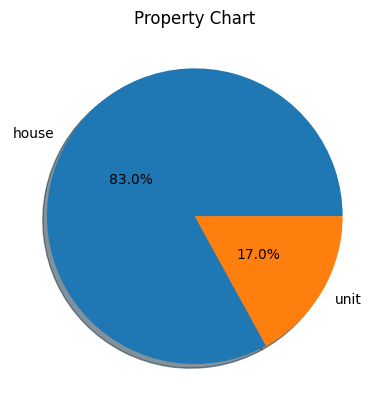

In [6]:
property_type_percentage = data['propertyType'].value_counts()
ax = plt.subplots()
ax = plt.pie(x=property_type_percentage, autopct="%.1f%%", labels=data['propertyType'].value_counts().keys(), pctdistance=0.5,shadow=True )
ax = plt.title('Property Chart')
plt.show()

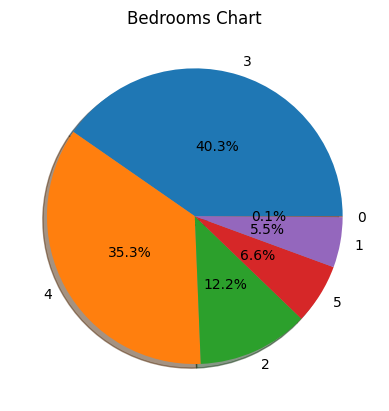

In [7]:
bedrooms_percentage = data['bedrooms'].value_counts()
ax = plt.subplots()
ax = plt.pie(x=bedrooms_percentage, autopct="%.1f%%", labels=data['bedrooms'].value_counts().keys(), pctdistance=0.5,shadow=True )
ax = plt.title('Bedrooms Chart')
plt.show()

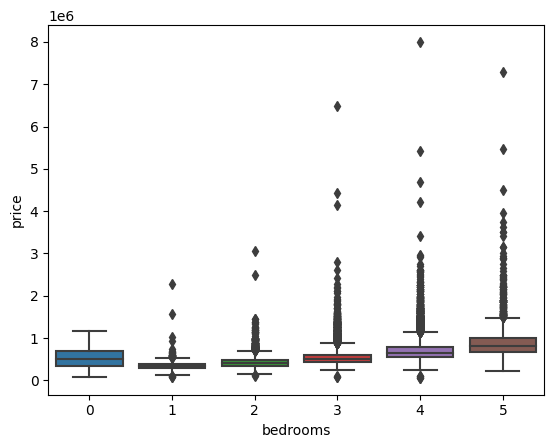

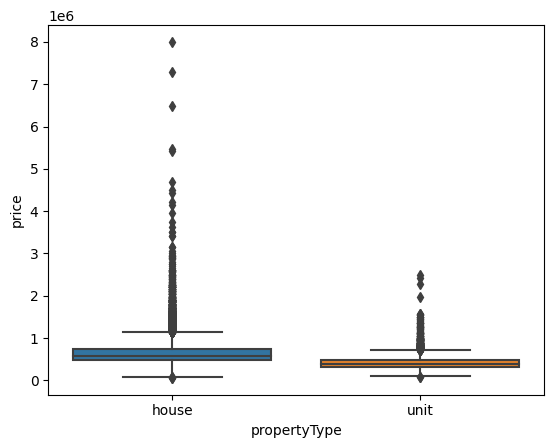

In [8]:
sns.boxplot(x="bedrooms", y="price", data=data)
plt.show()

sns.boxplot(x="propertyType", y="price", data=data)
plt.show()

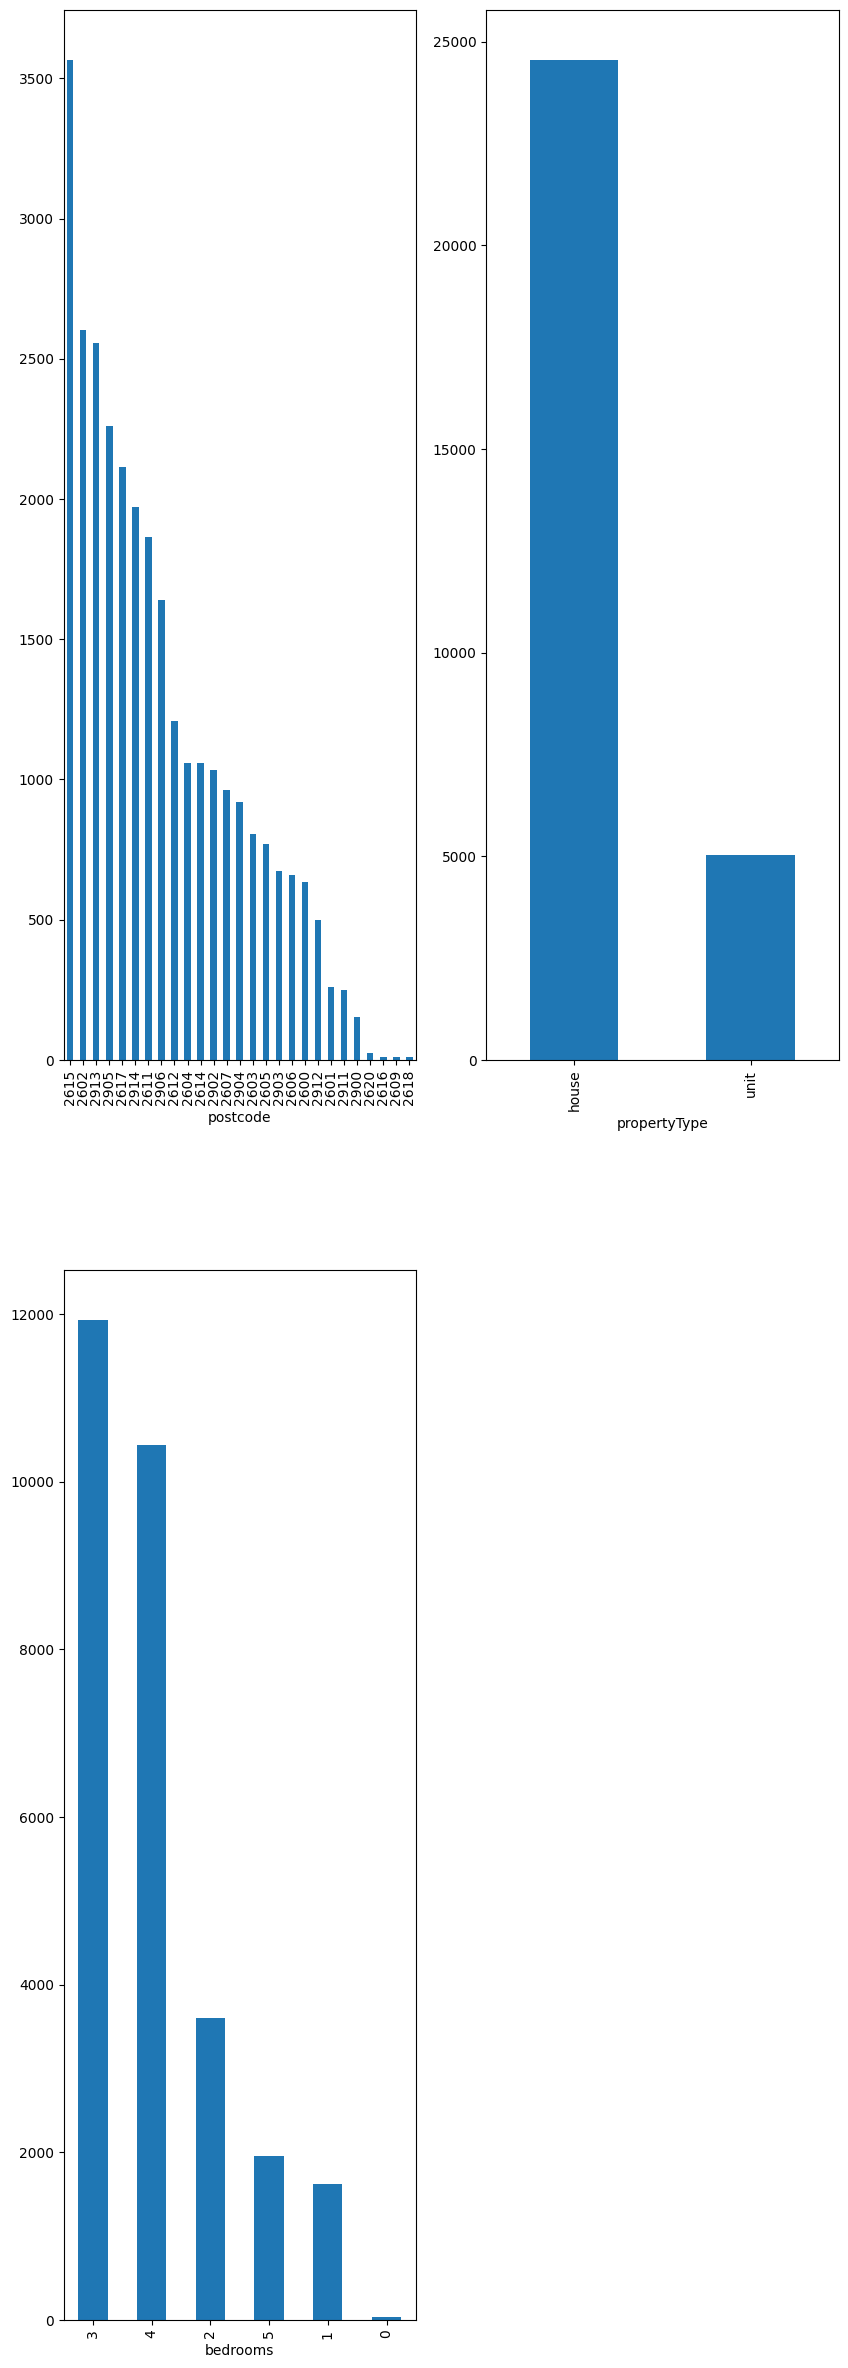

In [9]:
#draw the sample distribution of each feature
import matplotlib.pyplot as plt

plt.figure(figsize=(10,30))
cols = ['postcode', 'propertyType','bedrooms']
for i in range(3):
    plt.subplot(2,2,i+1)
    data[cols[i]].value_counts().plot(kind='bar')

plt.show()

<Axes: xlabel='datesold'>

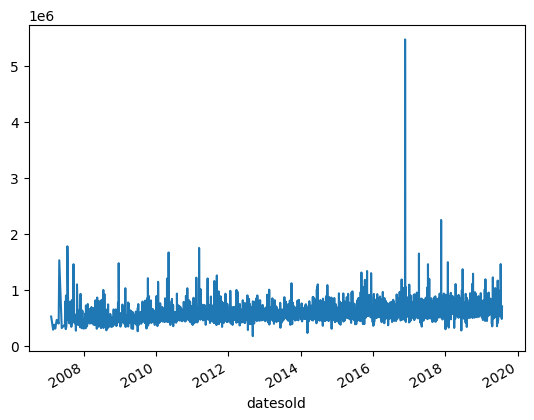

In [10]:
data.groupby(by=["datesold"])["price"].mean().plot()

In [11]:
data = data[(data.propertyType=="house") & (data.bedrooms==3)]
len(data)

11281

In [12]:
data_daily = data.resample('M', on='datesold').last()
len(data_daily)

/tmp/ipykernel_34/704934059.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_daily = data.resample('M', on='datesold').last()


150

In [13]:
#check missing value
data_daily[pd.isnull(data_daily.price)]

,postcode,price,propertyType,bedrooms,year,month
datesold,,,,,,


<Axes: xlabel='datesold'>

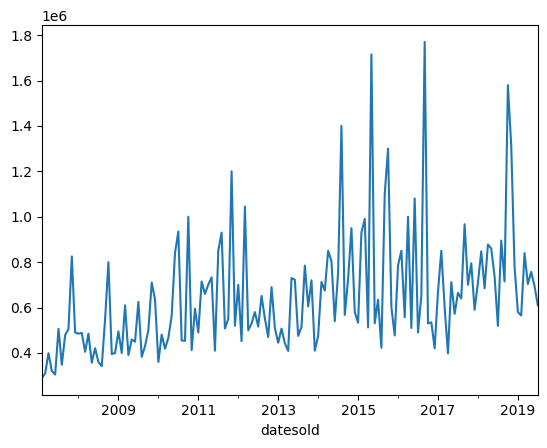

In [14]:
data_daily = data_daily.groupby(by=["datesold"])["price"].mean()
data_daily.plot()


<Axes: xlabel='datesold'>

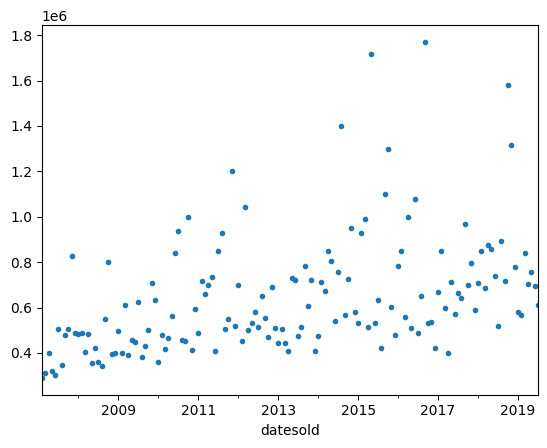

In [15]:
data_daily.plot(style='.')

In [16]:
data1 = data[["price","bedrooms","postcode"]]


In [17]:
data1.corr()

,price,bedrooms,postcode
price,1.000000,NaN,-0.379599
bedrooms,NaN,NaN,NaN
postcode,-0.379599,NaN,1.000000


In [18]:
data1.mode()


,price,bedrooms,postcode
0,450000,3,2615


In [19]:
data1.mean()


price       550263.885826
bedrooms         3.000000
postcode      2740.360695
dtype: float64

In [20]:
data1.median()

price       496000.0
bedrooms         3.0
postcode      2615.0
dtype: float64

## 1-2 Time series decompose

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def decomposing(timeseries, model, period=365):
    decomposition = seasonal_decompose(timeseries, model=model,period=period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(16, 12))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.show()

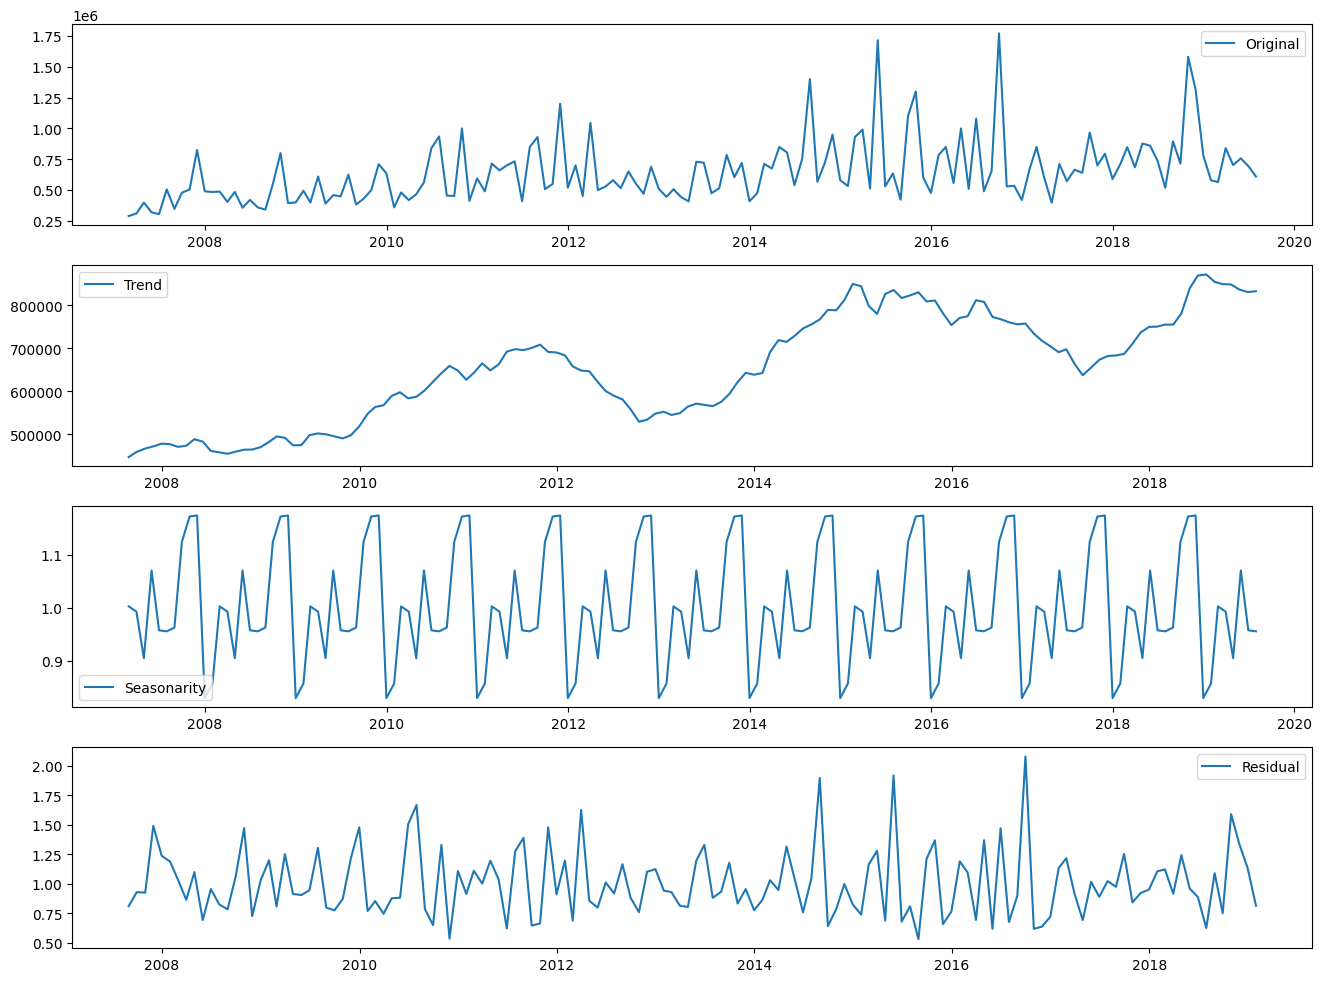

In [22]:
decomposing(data_daily,'multiplicative',12)

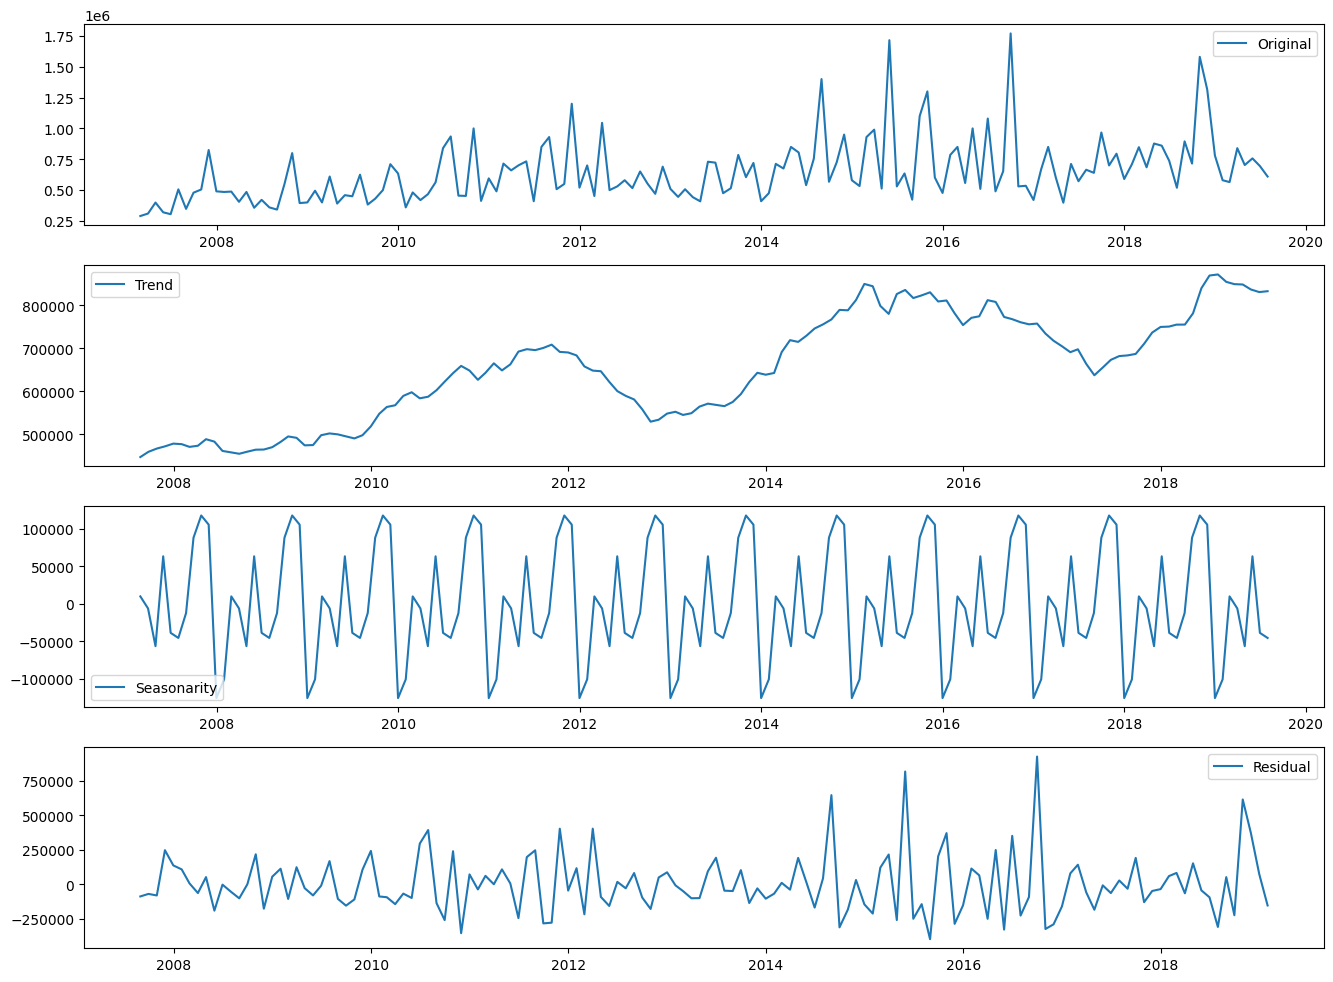

In [23]:
decomposing(data_daily,'additive',12)

In [24]:
#split dataset into train and test
#There is an abnormal spike in 2018. I just cut data to 2017
train = data_daily.loc['2007-01-01':'2016-01-01']
test = data_daily.loc['2016-01-01':'2017-12-31']
train.head()

datesold
2007-02-28    290000.0
2007-03-31    310000.0
2007-04-30    399000.0
2007-05-31    320000.0
2007-06-30    305000.0
Freq: ME, Name: price, dtype: float64

## 1-3 Stationary or Non stationary ADF testing

In [25]:
from statsmodels.tsa.stattools import adfuller as ADF

timeseries_adf = ADF(train)
print('timeseries_adf : ', timeseries_adf)

timeseries_adf :  (-2.0227303431048673, 0.27669641660490296, 5, 101, {'1%': -3.4968181663902103, '5%': -2.8906107514600103, '10%': -2.5822770483285953}, 2566.222875011653)


Since pvalue 0.277 is greater than 0.05, we cannot reject null hypothese that time series is non stationary. Let's transfrom the data firstly

In [26]:
import math
#log transform
data_log = train.apply(lambda x: math.log(x))
print('log_adf : ', ADF(data_log))
#first difference transform
data_diff = train.diff(1).fillna(0)
print('diff_adf : ', ADF(data_diff))

log_adf :  (-3.0794223737736606, 0.028113980765804902, 3, 103, {'1%': -3.4954932834550623, '5%': -2.8900369024285117, '10%': -2.5819706975209726}, 54.70251499536562)
diff_adf :  (-7.252257095984944, 1.767533958266655e-10, 5, 101, {'1%': -3.4968181663902103, '5%': -2.8906107514600103, '10%': -2.5822770483285953}, 2566.717540847511)


## 1-4 ACF and PACF

In [27]:
import statsmodels.api as sm

def acf_pacf(data, lags):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()

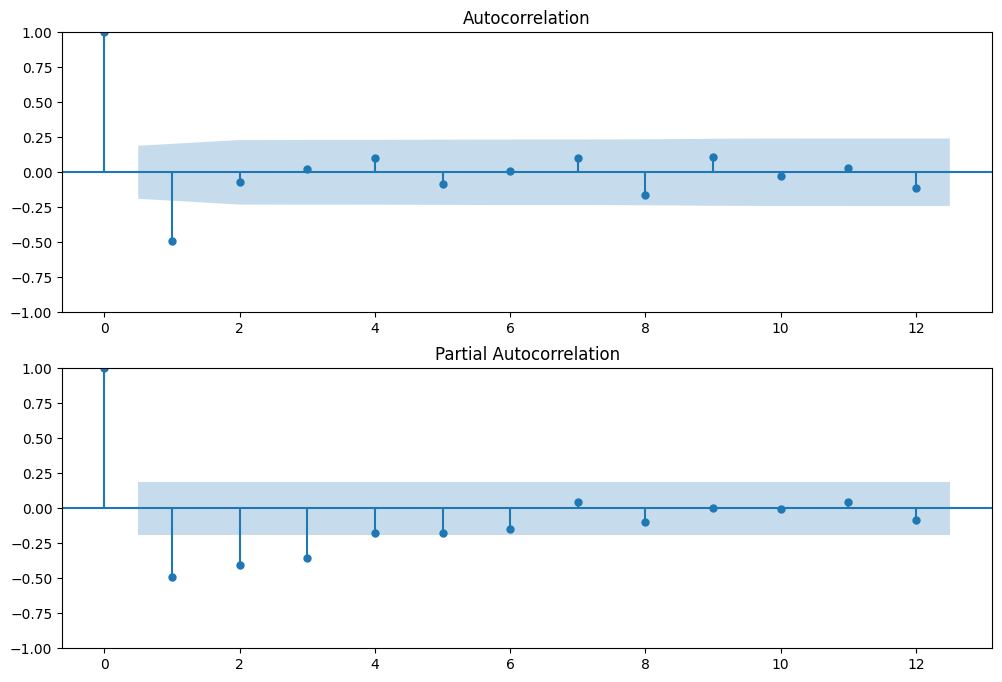

In [28]:
acf_pacf(data_diff, 12)

Accoridng to acf&pacf, for first difference PACF declines gradually while ACF drops instancly, thus a moving average model should suit better and p=3, q=1, d=1 is recommended.

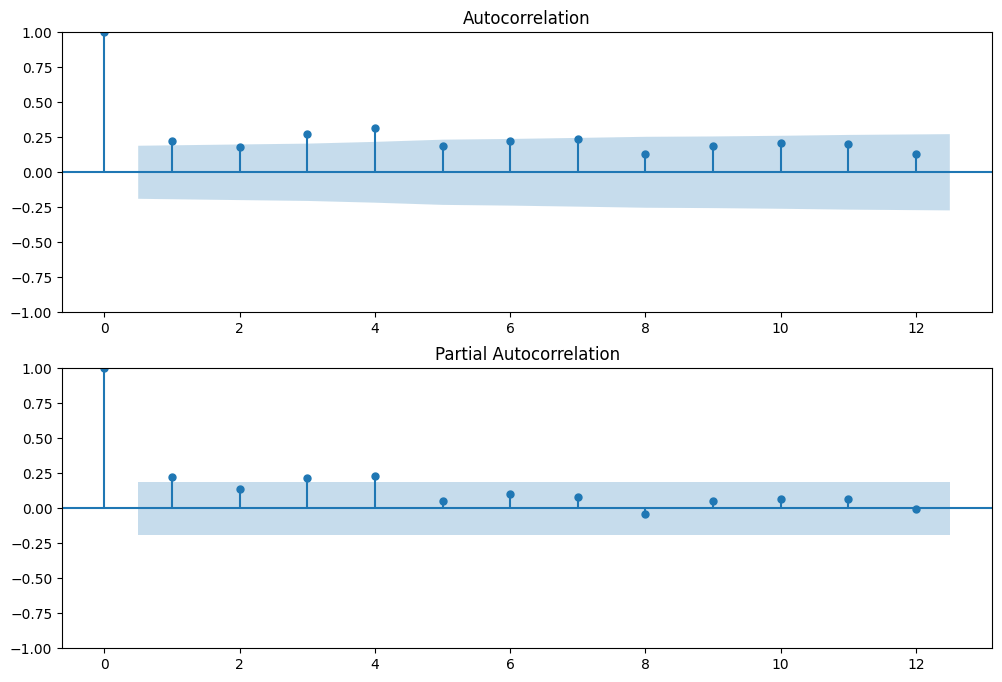

In [29]:
acf_pacf(data_log, 12)

## 1-5 AIC & BIC

In [30]:
import statsmodels.api as sm

evaluate = sm.tsa.arma_order_select_ic(data_diff, ic=['aic', 'bic'],  max_ar=4,
                                            max_ma=4)
print('AIC', evaluate.aic_min_order)
print('BIC', evaluate.bic_min_order)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC (0, 3)
BIC (0, 1)


# 2 Model training

## 2-1 ARIMA

### 2-1-1 Model training

In [31]:
train.index = train.index.to_period("M")
test.index = test.index.to_period("M")

In [32]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

def model_train(train,order,test):
    history = [x for x in train]
    predictions=[]
    for i in range(len(test)):
        model = ARIMA(history, order=order)
        trend_model = model.fit()
        output = trend_model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[i]
        history.append(obs)
        #print("predicted=%f, expected=%f" %(yhat,obs))
    rmse = sqrt(mean_squared_error(test,predictions))
    
    return trend_model, rmse, predictions
    

In [33]:
model311, rmse311, _ = model_train(train,(3,1,1),test)
print("model311 rmse=%f" %(rmse311))
model013, rmse013,_ = model_train(train,(0,1,3),test)
print("model013 rmse=%f" %(rmse013))
model011, rmse011,_ = model_train(train,(0,1,1),test)
print("model011 rmse=%f" %(rmse011))

/tmp/ipykernel_34/2637335490.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[i]


model311 rmse=297011.884125


/tmp/ipykernel_34/2637335490.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[i]


model013 rmse=289737.186836


/tmp/ipykernel_34/2637335490.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[i]


model011 rmse=292319.736641


### 2-1-2 Grid search finetuning

In [34]:
import warnings
warnings.filterwarnings("ignore")

pvalues = [0,1,2,3]
dvalues = [0,1]
qvalues = [0,1,2,3]

r = 289737.186859
for p in pvalues:
    for d in dvalues:
        for q in qvalues:
            model, rmse, _ = model_train(train,(p,d,q),test)            
            if rmse<r:
                model_best = model
                r = rmse
                order = (p,d,q)
            print("pvalue=%d,dvalue=%d,qvalue=%d" %(p,d,q))

pvalue=0,dvalue=0,qvalue=0
pvalue=0,dvalue=0,qvalue=1
pvalue=0,dvalue=0,qvalue=2
pvalue=0,dvalue=0,qvalue=3
pvalue=0,dvalue=1,qvalue=0
pvalue=0,dvalue=1,qvalue=1
pvalue=0,dvalue=1,qvalue=2
pvalue=0,dvalue=1,qvalue=3
pvalue=1,dvalue=0,qvalue=0
pvalue=1,dvalue=0,qvalue=1
pvalue=1,dvalue=0,qvalue=2
pvalue=1,dvalue=0,qvalue=3
pvalue=1,dvalue=1,qvalue=0
pvalue=1,dvalue=1,qvalue=1
pvalue=1,dvalue=1,qvalue=2
pvalue=1,dvalue=1,qvalue=3
pvalue=2,dvalue=0,qvalue=0
pvalue=2,dvalue=0,qvalue=1
pvalue=2,dvalue=0,qvalue=2
pvalue=2,dvalue=0,qvalue=3
pvalue=2,dvalue=1,qvalue=0
pvalue=2,dvalue=1,qvalue=1
pvalue=2,dvalue=1,qvalue=2
pvalue=2,dvalue=1,qvalue=3
pvalue=3,dvalue=0,qvalue=0
pvalue=3,dvalue=0,qvalue=1
pvalue=3,dvalue=0,qvalue=2
pvalue=3,dvalue=0,qvalue=3
pvalue=3,dvalue=1,qvalue=0
pvalue=3,dvalue=1,qvalue=1
pvalue=3,dvalue=1,qvalue=2
pvalue=3,dvalue=1,qvalue=3


In [35]:
order

(1, 0, 2)

In [36]:
model102, rmse102, predictions = model_train(train,(1,0,2),test)

### 2-1-3 evaluation

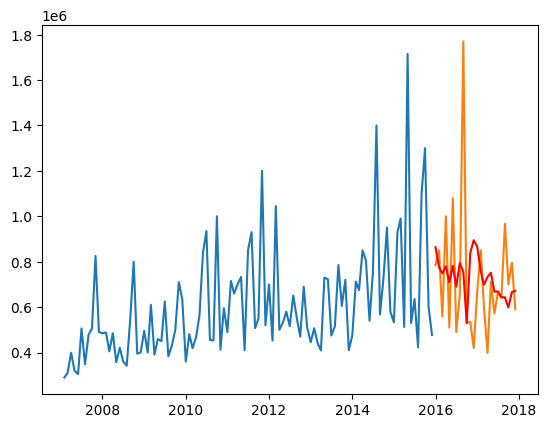

In [37]:
train_post = train.to_timestamp(how="start").rename_axis("saledate").reset_index(name='sale')
test_post = test.to_timestamp(how="start").rename_axis("saledate").reset_index(name='sale')

from matplotlib import pyplot

pyplot.plot(train_post.saledate,train_post.sale)
pyplot.plot(test_post.saledate,test_post.sale)
pyplot.plot(test_post.saledate,predictions,color='red')
pyplot.show()


In [38]:
model102.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  130
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1791.252
Date:                Tue, 06 May 2025   AIC                           3592.503
Time:                        07:55:44   BIC                           3606.841
Sample:                             0   HQIC                          3598.329
                                - 130                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.238e+05   9.89e+04      6.309      0.000     4.3e+05    8.18e+05
ar.L1          0.9768      0.028     34.285      0.000       0.921       1.033
ma.L1         -1.1118      0.128     -8.684      0.000      -1.363      -0.861
ma.L2          0.2357      0.121      1.951      0.051      -0.001       0.472
sigma2      5.655e+10      1.093   5.17e+10      0.000    5.65e+10    5.65e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               132.37
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               3.86   Skew:                             1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.8e+26. Standard errors may be unstable.
"""

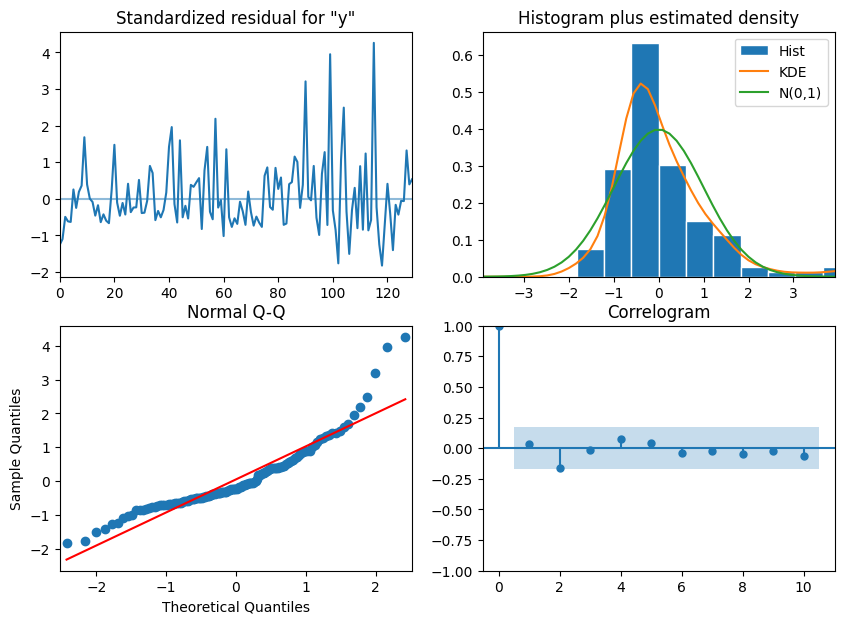

In [39]:
model102.plot_diagnostics(figsize=(10,7))
plt.show()

## 2-2 Prophet

### 2-2-1 model training

In [40]:
from prophet import Prophet

In [41]:
#get data ready for prophet
df_train_prophet = train_post.rename(columns={"saledate":"ds","sale":"y"})
df_train_prophet.head()

,ds,y
0,2007-02-01,290000.0
1,2007-03-01,310000.0
2,2007-04-01,399000.0
3,2007-05-01,320000.0
4,2007-06-01,305000.0


In [42]:
model_prophet = Prophet()
model_prophet.fit(df_train_prophet)

07:55:46 - cmdstanpy - INFO - Chain [1] start processing
07:55:46 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
df_future = model_prophet.make_future_dataframe(periods=24,freq="MS")
future_forecast = model_prophet.predict(df_future)
future_forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
126,2017-08-01,864682.672850,619876.470263,1.121146e+06
127,2017-09-01,861162.992913,616562.218776,1.134690e+06
128,2017-10-01,973950.925972,719856.804684,1.231643e+06
129,2017-11-01,980829.652452,719502.806259,1.251963e+06
130,2017-12-01,773467.121433,514764.825242,1.027180e+06


In [44]:
def display_forecast(forecast):
    forecast_plot = model_prophet.plot(forecast)

    axes = forecast_plot.gca()
    last_training_date= df_train_prophet.ds.iloc[-1]
    axes.axvline(x=last_training_date,color='red',linestyle='--', label = 'Training End')

    plt.plot(test_post.saledate, test_post.sale,'ro',markersize=3,label = 'True Test Data')
    plt.legend()

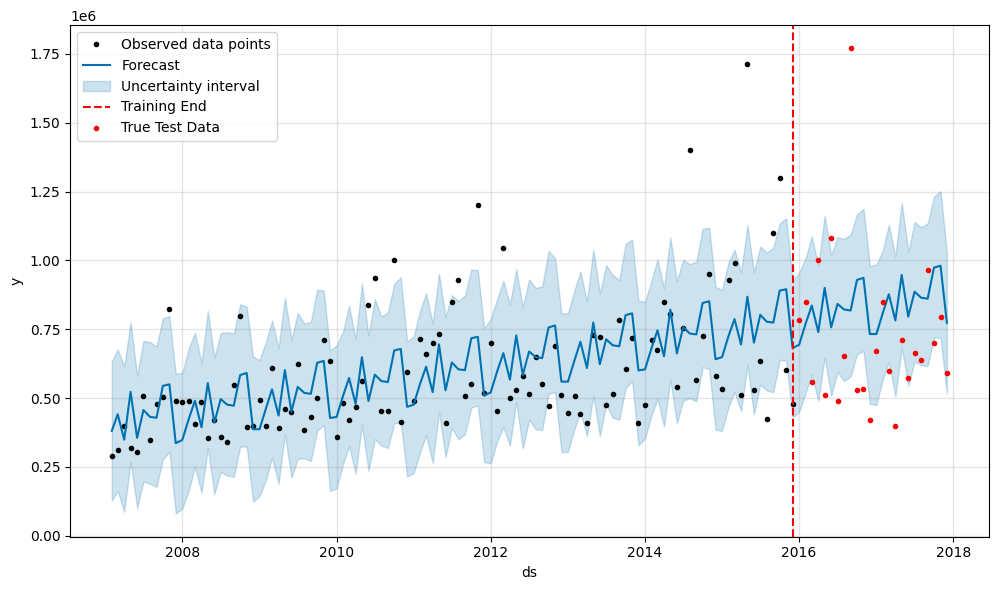

In [45]:
display_forecast(future_forecast)

In [46]:
sqrt(mean_squared_error(test_post.sale,future_forecast.yhat[-24:]))

321708.3317579143

### 2-2-2 Fine tuning

In [47]:
from sklearn.model_selection import ParameterGrid
params_grid = {'changepoint_prior_scale':[0.1,0.2],
               'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}
grid = ParameterGrid(params_grid)

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         seasonality_prior_scale = p['seasonality_prior_scale'],
                         seasonality_mode = "additive",
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         interval_width=0.95)
    train_model.fit(df_train_prophet)
    train_forecast = train_model.make_future_dataframe(periods=24,freq="MS",include_history = False)
    train_forecast = train_model.predict(train_forecast)
    RMSE = sqrt(mean_squared_error(test_post.sale,train_forecast.yhat))
    print('Root_mean_squared_error (RMSE)------------------------------------',RMSE)
    model_parameters = pd.concat([model_parameters,pd.DataFrame({'RMSE':RMSE,'Parameters':p})],ignore_index=True)

07:55:46 - cmdstanpy - INFO - Chain [1] start processing
07:55:46 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


07:55:47 - cmdstanpy - INFO - Chain [1] start processing
07:55:47 - cmdstanpy - INFO - Chain [1] done processing


Root_mean_squared_error (RMSE)------------------------------------ 309116.6829552667
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


07:55:47 - cmdstanpy - INFO - Chain [1] start processing
07:55:47 - cmdstanpy - INFO - Chain [1] done processing


Root_mean_squared_error (RMSE)------------------------------------ 320408.0575248144
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


07:55:47 - cmdstanpy - INFO - Chain [1] start processing
07:55:47 - cmdstanpy - INFO - Chain [1] done processing


Root_mean_squared_error (RMSE)------------------------------------ 307023.96865814086
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


07:55:48 - cmdstanpy - INFO - Chain [1] start processing
07:55:48 - cmdstanpy - INFO - Chain [1] done processing


Root_mean_squared_error (RMSE)------------------------------------ 307022.27147154824
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}


07:55:48 - cmdstanpy - INFO - Chain [1] start processing
07:55:48 - cmdstanpy - INFO - Chain [1] done processing


Root_mean_squared_error (RMSE)------------------------------------ 316083.91179077607
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.1}


07:55:48 - cmdstanpy - INFO - Chain [1] start processing
07:55:48 - cmdstanpy - INFO - Chain [1] done processing


Root_mean_squared_error (RMSE)------------------------------------ 324131.72100089386
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0}


07:55:49 - cmdstanpy - INFO - Chain [1] start processing
07:55:49 - cmdstanpy - INFO - Chain [1] done processing


Root_mean_squared_error (RMSE)------------------------------------ 316133.9045023499
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0}
Root_mean_squared_error (RMSE)------------------------------------ 312702.8280773314


<Axes: >

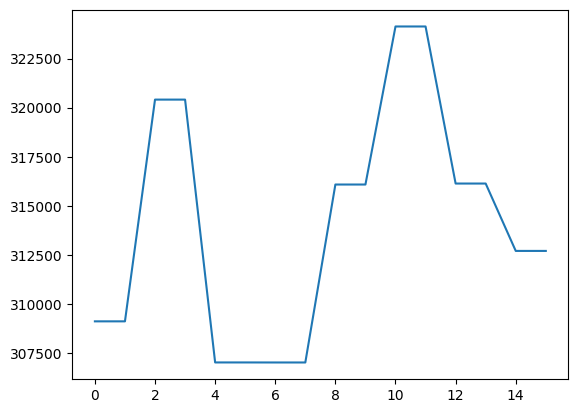

In [48]:
model_parameters.RMSE.plot()

In [49]:
model_parameters.RMSE.min()

307022.27147154824

In [50]:
model_parameters[model_parameters.RMSE==model_parameters.RMSE.min()].Parameters

6     0.1
7    10.0
Name: Parameters, dtype: float64

07:55:49 - cmdstanpy - INFO - Chain [1] start processing
07:55:49 - cmdstanpy - INFO - Chain [1] done processing


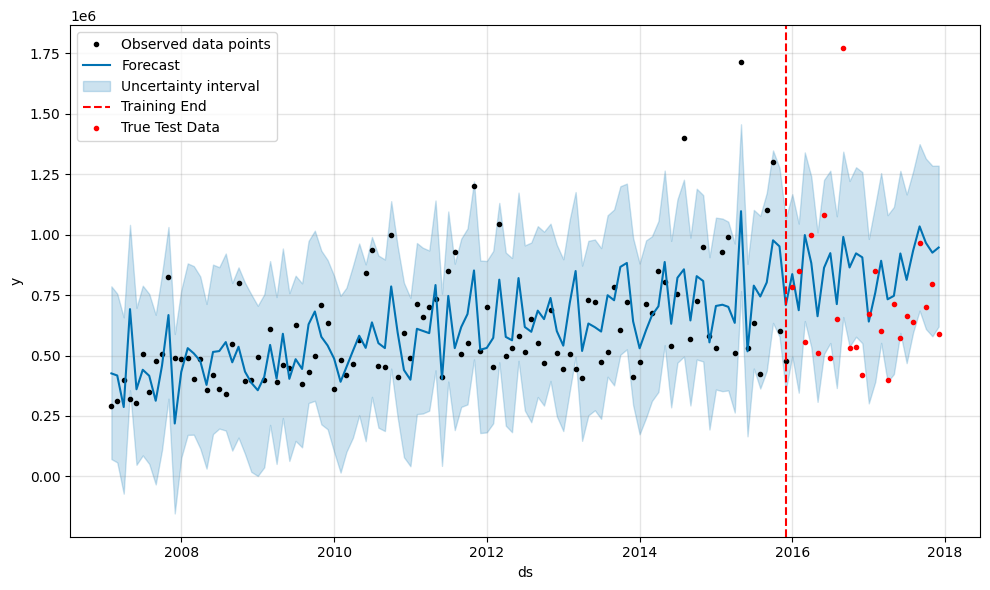

In [51]:
model_prophet = Prophet(changepoint_prior_scale = 0.1,
                         seasonality_prior_scale = 10,
                         seasonality_mode = "additive",
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         interval_width=0.95)
model_prophet.fit(df_train_prophet)
df_future = model_prophet.make_future_dataframe(periods=24,freq="MS")
future_forecast = model_prophet.predict(df_future)
display_forecast(future_forecast)

## Using LSTM

In [52]:

df_grouped['count'] = 1

In [53]:
#Converting string to date and creating some adiction columns based on the date
df_grouped['datesold'] = pd.to_datetime(df_grouped['datesold'])
df_grouped = df_grouped.sort_values(by=['datesold'])
df_grouped['month'] = df_grouped['datesold'].dt.month
df_grouped['year'] = df_grouped['datesold'].dt.year
df_grouped['date'] = df_grouped.apply(lambda x: str(x['year']) + '/' + "{:02d}".format(x['month']), axis = 1)

In [54]:
import itertools

# This function will create a "dummy" sale for every month, type of propert and number of bedrooms
def add_group_row(df, columns):
    value_counts_columns = []
    for column in columns:
        value_counts_columns.append(df[column].value_counts().index)
    list_combinations = list(itertools.product(*value_counts_columns))
    for index, row in enumerate(list_combinations):
        list_combinations[index] = [i for i in row]
        list_combinations[index].append(0)
        list_combinations[index].append(1)
    return list_combinations

columns = ['date','propertyType','bedrooms']
rows_to_add = add_group_row(df_grouped, columns)

In [55]:
# We create a data frame for our dummies to concat with the original dataset 
columns_names = ['date','propertyType','bedrooms', 'price', 'count']
df_rows_to_add = pd.DataFrame(rows_to_add, columns=columns_names)
df_rows_to_add.head()

,date,propertyType,bedrooms,price,count
0,2017/11,house,3,0,1
1,2017/11,house,4,0,1
2,2017/11,house,2,0,1
3,2017/11,house,5,0,1
4,2017/11,house,1,0,1


In [56]:
df_grouped = df_grouped[columns_names]
# Concatening the original dataset with the dummies
df_grouped_new = pd.concat([df_grouped, df_rows_to_add])
df_grouped_new = df_grouped_new.reset_index(drop=True)
df_grouped_new

,date,propertyType,bedrooms,price,count
0,2007/02,house,4,525000,1
1,2007/02,house,3,290000,1
2,2007/03,house,3,328000,1
3,2007/03,house,4,380000,1
4,2007/03,house,3,310000,1
...,...,...,...,...,...
31375,2007/02,unit,4,0,1
31376,2007/02,unit,2,0,1
31377,2007/02,unit,5,0,1
31378,2007/02,unit,1,0,1


In [57]:
# Here we make the price mean manually
df_grouped_new = df_grouped_new.groupby(by=['date', 'propertyType', 'bedrooms']).sum()
df_grouped_new['price_mean'] = df_grouped_new.apply(lambda x: x['price'] if x['count'] == 1 else x['price'] / (x['count'] - 1), axis= 1)
df_grouped_new.head()

price  count  price_mean
date    propertyType bedrooms                           
2007/02 house        0              0      1         0.0
                     1              0      1         0.0
                     2              0      1         0.0
                     3         290000      2    290000.0
                     4         525000      2    525000.0

In [58]:
# Create first date and last date based on the dates available on the dataset
first_date = df_grouped_new.index[0][0]
year, month = first_date.split('/')
first_year, first_month = int(year), int(month)
last_date = df_grouped_new.index[-1][0]
year, month = last_date.split('/')
last_year, last_month = int(year), int(month)

In [59]:
# Take all the values for the columns indicated
value_counts_property = df_grouped['propertyType'].value_counts().index
value_counts_bedrooms = df_grouped['bedrooms'].value_counts().index

#Combine all the values from value_counts_property and value_counts_bedrooms
first_indexes = list(itertools.product([first_date],value_counts_property, value_counts_bedrooms))

# This function replace all the initial values of each type of property if they're 0 with the closeset month with any sale
# whith the same type of property
for index in first_indexes:
    # Verify if the first element just have one count, meaning it's just the dummy we putted before
    if df_grouped_new.loc[index]['count'] == 1:
        origin_property_type = index[1]
        origin_bedrooms = index[2]
        # search for the most recent sale of the same type to replace in the price_mean
        for year in range(first_year, last_year + 1):
            begin_month = 1
            end_month = 12
            if year == first_year:
                begin_month = first_month + 1
            elif year == last_year:
                end_month = last_month
            for month in range(begin_month, end_month + 1):
                current_date = str(year) + '/' + "{:02d}".format(month)
                current_row = df_grouped_new.loc[(current_date, origin_property_type, origin_bedrooms)]
                if current_row['price_mean'] > 0:
                    df_grouped_new.at[index, 'price_mean'] = current_row['price_mean']
                    break
            if df_grouped_new.loc[index]['price_mean'] > 0:
                break
            
df_grouped_new.head()

price  count  price_mean
date    propertyType bedrooms                           
2007/02 house        0              0      1    415000.0
                     1              0      1    327000.0
                     2              0      1    320000.0
                     3         290000      2    290000.0
                     4         525000      2    525000.0

In [60]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Function to make a mean between the current month and the previous one
# and to replace any zeros with the previous value of price_mean
for index in df_grouped_new.index:
    if index[0] == first_date:
        continue
    date_obj = datetime.strptime(index[0], '%Y/%m')
    previous_date_obj = date_obj - relativedelta(months=1)
    previous_date_str = str(previous_date_obj.year) + '/' + "{:02d}".format(previous_date_obj.month)
    previous_index = (previous_date_str, index[1], index[2])
    if df_grouped_new.loc[index]['count'] == 1:
        df_grouped_new.at[index, 'price_mean'] = df_grouped_new.loc[previous_index]['price_mean']
    else:
         df_grouped_new.at[index, 'price_mean'] = (df_grouped_new.loc[previous_index]['price_mean']
                                                + df_grouped_new.loc[index]['price_mean'])/2

df_grouped_new.head(20)

price  count  price_mean
date    propertyType bedrooms                           
2007/02 house        0              0      1    415000.0
                     1              0      1    327000.0
                     2              0      1    320000.0
                     3         290000      2    290000.0
                     4         525000      2    525000.0
                     5              0      1    667500.0
        unit         0              0      1     90000.0
                     1              0      1    351000.0
                     2              0      1    300000.0
                     3              0      1    480000.0
                     4              0      1    550000.0
                     5              0      1   1490000.0
2007/03 house        0              0      1    415000.0
                     1              0      1    327000.0
                     2              0      1    320000.0
                     3         638000      3    304500.0
                     4         380000      2    452500.0
                     5              0      1    667500.0
        unit         0              0      1     90000.0
                     1              0      1    351000.0

In [61]:
window = 5
# Here we create our feature and target datasets with the structure of a time series
df_grouped_chaged = df_grouped_new.reset_index().sort_values(by=['propertyType', 'bedrooms', 'date'])
feature, target = [], []
bedrooms =  df_grouped_chaged.iloc[0]['bedrooms']
# This value is the window size we are using
index = window
while(index < df_grouped_chaged.shape[0]):
    if bedrooms != df_grouped_chaged.iloc[index]['bedrooms']:
        bedrooms = df_grouped_chaged.iloc[index]['bedrooms']
        index = index + window
    feature.append(df_grouped_chaged.iloc[index - window: index]['price_mean'].to_numpy())
    target.append(df_grouped_chaged.iloc[index][['price_mean', 'date']].to_numpy())
    index = index + 1
feature = np.array(feature)
target = np.array(target)       

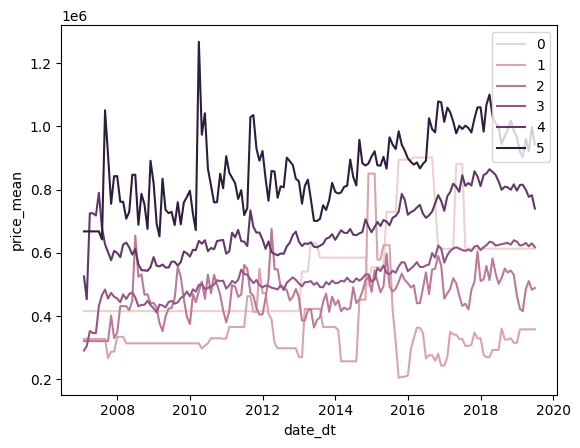

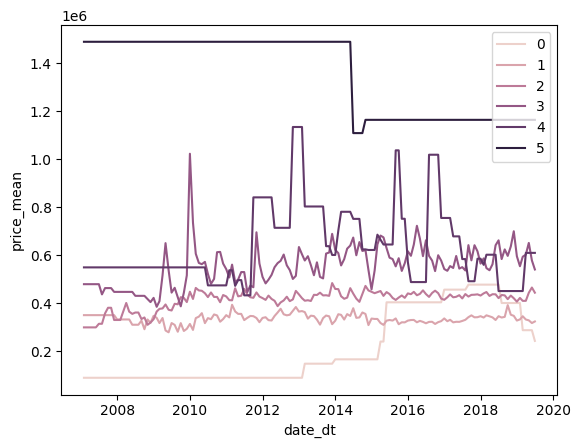

In [62]:
df_aux = df_grouped_new.reset_index()
df_aux['date_dt'] = pd.to_datetime(df_aux['date'], format='%Y/%m') 
sns.lineplot(data = df_aux.query('propertyType == "house"'), x = 'date_dt', y = 'price_mean', hue = 'bedrooms')
plt.legend(loc='upper right')
plt.show()

sns.lineplot(data = df_aux.query('propertyType == "unit"'), x = 'date_dt', y = 'price_mean', hue = 'bedrooms')
plt.legend(loc='upper right')
plt.show()

In [63]:

size_test_perc = 0.9

# creating the separation so we can create our test and train datasets
size_test = int(df_grouped['date'].value_counts().index.shape[0] * size_test_perc)
separation_date = df_grouped['date'].value_counts().index.sort_values()[size_test]

In [64]:
size_test_perc = 0.9
# This function creates our train and test dataset based on the date inserted on the target
x_train, y_train, x_test, y_test = [], [], [], []
for i,t in enumerate(target):
    if t[1] <= separation_date:
        x_train.append(feature[i])
        y_train.append(target[i][0])
    else:
        x_test.append(feature[i])
        y_test.append(target[i][0])

In [65]:
x_train, x_test = np.array(x_train), np.array(x_test)
y_train, y_test = np.array(y_train).reshape(-1, 1), np.array(y_test).reshape(-1, 1)

In [66]:
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

# Scaling feature and target separately
scaler_feature = StandardScaler()
scaler_feature.fit(x_train)
x_train = scaler_feature.transform(x_train)
x_test = scaler_feature.transform(x_test)

# Reshaping features for the LSTM
x_train, x_test = x_train.reshape(-1,window,1), x_test.reshape(-1,window,1)

scaler_target = StandardScaler()
scaler_target.fit(y_train)
y_train = scaler_target.transform(y_train)
y_test = scaler_target.transform(y_test)

2025-05-06 07:55:55.237688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-06 07:55:55.237815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-06 07:55:55.377354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [67]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units = 128, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.LSTM(units = 128))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='RMSProp')
model.summary()


result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.1941 - val_loss: 0.0251
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0654 - val_loss: 0.0206
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0582 - val_loss: 0.0189
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0501 - val_loss: 0.0305
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0599 - val_loss: 0.0198
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0520 - val_loss: 0.0372
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0512 - val_loss: 0.0147
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0444 - val_loss: 0.0132
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0429 - val_loss: 0.0198
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0369 - val_loss: 0.0260


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


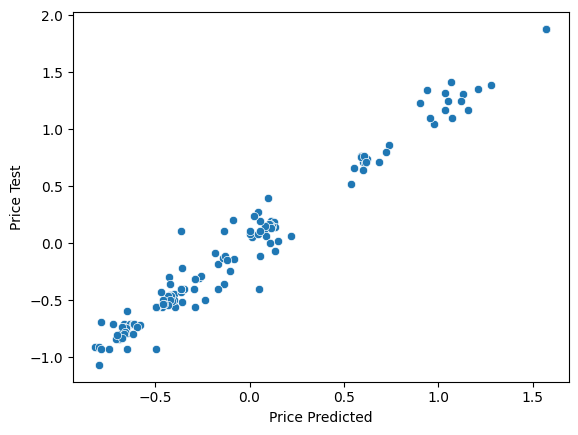

In [68]:
y_predicted = model.predict(x_test)

ax = sns.scatterplot(x=y_predicted[:,0], y=y_test[:,0])
ax.set_ylabel('Price Test')
ax.set_xlabel('Price Predicted')
plt.show()